# pix2pix

## Load images

## download dataset

In [1]:
import os

path = "datasets/kitti/depth_selection/val_selection_cropped/"

if not os.path.isdir(path):
    ! mkdir -p datasets/kitti
    ! wget -O datasets/kitti.zip https://s3.eu-central-1.amazonaws.com/avg-kitti/data_depth_selection.zip
    ! unzip -q -o datasets/kitti.zip -d datasets/kitti

### common dependencies

In [2]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import csv
import random
import math
from PIL import Image
from tqdm import tqdm

## load dataset

In [26]:
xs = []
ys = []

num_samples = 600

for image_path in tqdm(glob.glob(path + "image/" + "*.png"), desc="Loading Images"):
    x = Image.open(image_path)
    x = x.convert('RGB')
    
    width = math.floor(x.size[0] * 256 / x.size[1])
    x_offset = random.randint(0, width - 256)
    
    x = x.resize((width, 256))
    x = x.crop((x_offset, 0, x_offset + 256, 256))
    xs.append(np.array(x.getdata()).reshape((256, 256, 3)) / 255)

    y = Image.open(image_path.replace('/image/', '/groundtruth_depth/').replace('sync_image', 'sync_groundtruth_depth'))
    y = y.convert('RGB')
    y = y.resize((width, 256))
    y = y.crop((x_offset, 0, x_offset + 256, 256))
    ys.append(np.array(y.getdata()).reshape((256, 256, 3)) / 255)
    
    if len(xs) >= num_samples:
        break;

xs = np.array(xs)
ys = np.array(ys)

Loading Images:  60%|█████▉    | 599/1000 [01:26<00:57,  6.92it/s]


#### Visualization of random images and their labels

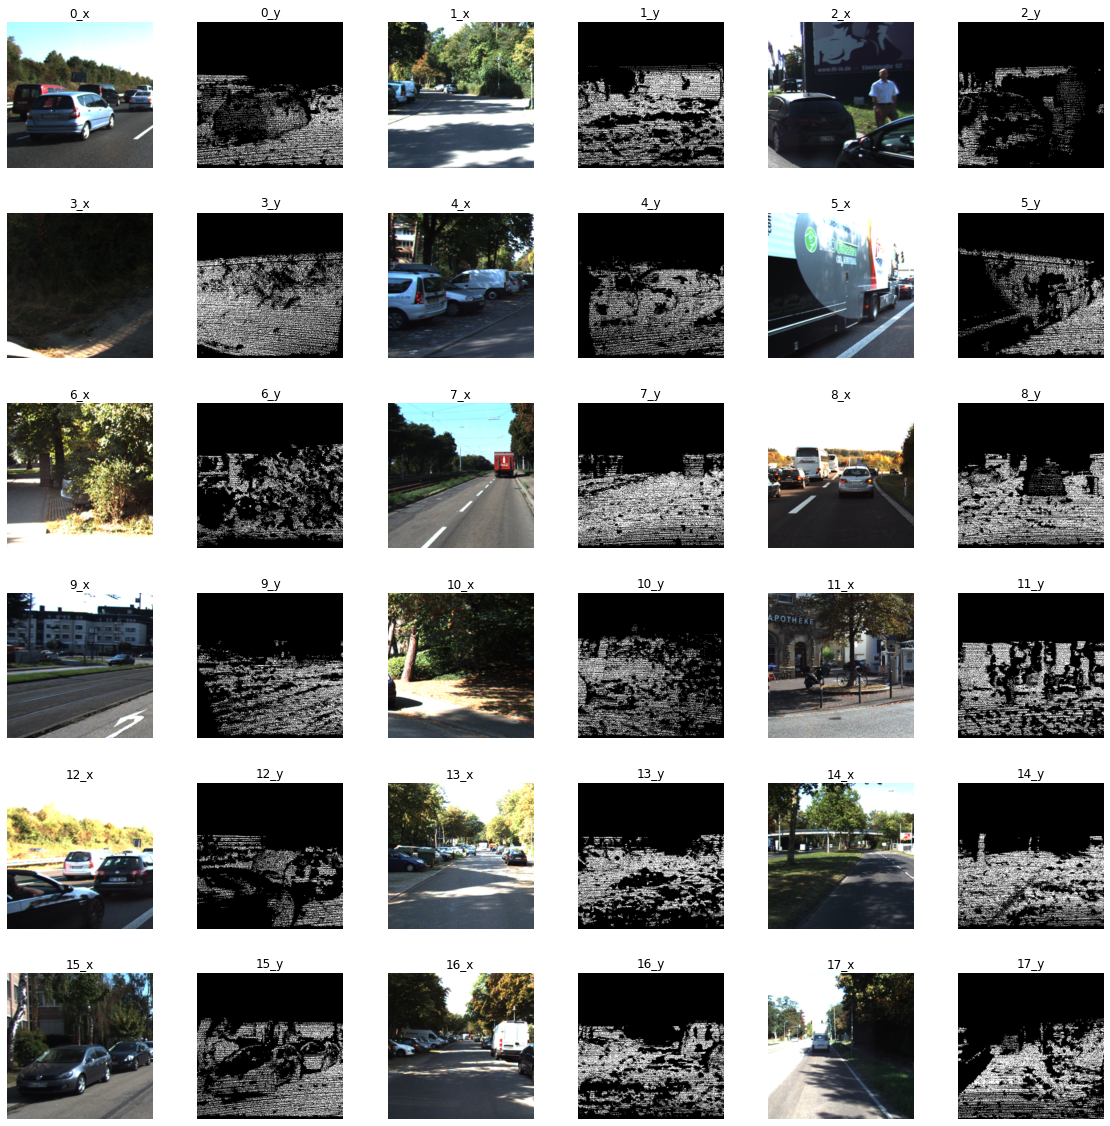

In [27]:
%matplotlib inline
fig, ax = plt.subplots(6,6,figsize=(16,16))
fig.tight_layout()
ax = ax.flatten()

for i in range(18):
    rand = np.random.randint(len(xs)-1)
    x = xs[rand]
    y = ys[rand]
    
    ax[2 * i].imshow(x)
    ax[2 * i].set_title(f"{i}_x")
    ax[2 * i].axis("off")
    ax[2 * i + 1].imshow(y)
    ax[2 * i + 1].set_title(f"{i}_y")
    ax[2 * i + 1].axis("off")

### import pix2pix and generate model

In [28]:
%run pix2pix.ipynb

model = Pix2pix()

### fit model

In [29]:
((train_x, train_y), (test_x, test_y)) = model.split_dataset(xs, ys, validation_split=0.05)

model.fit(train_x, train_y, batch_size=10, epochs=150, validation_data=(test_x, test_y))

Training Progress: 100%|██████████| 150/150 [3:38:30<00:00, 87.40s/it]  


### visualize results of test data

<ipython-input-30-44595941af83>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,3,figsize=(10,10))


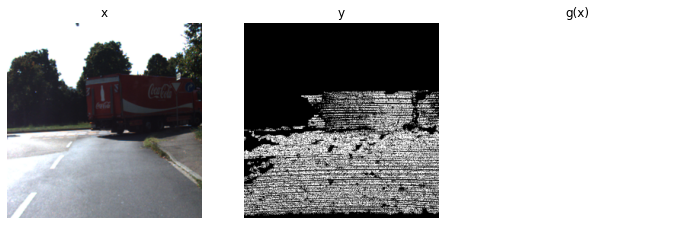

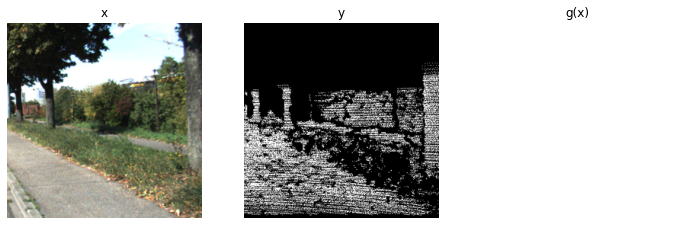

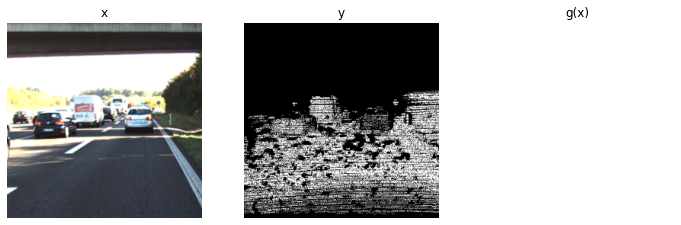

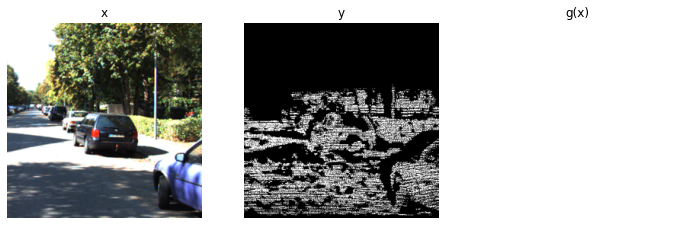

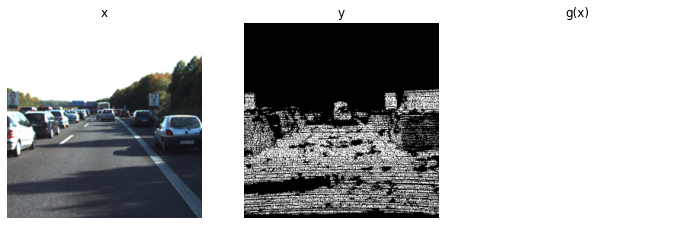

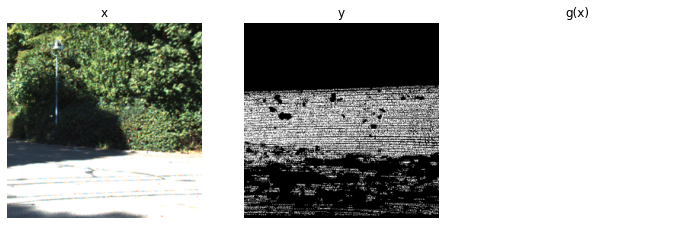

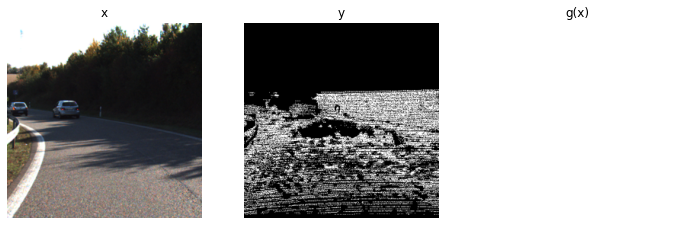

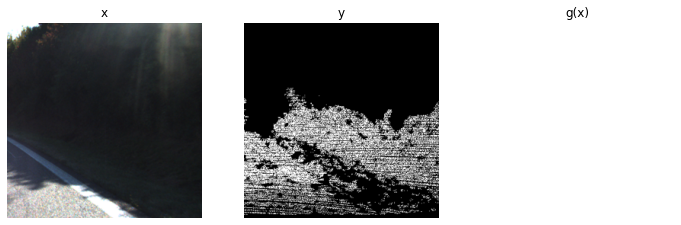

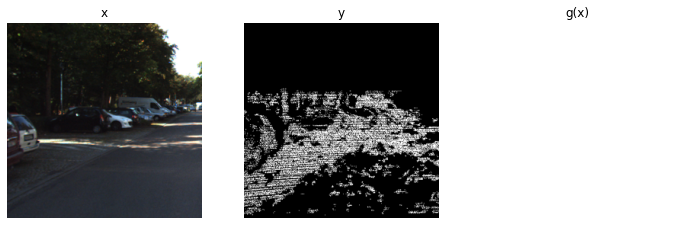

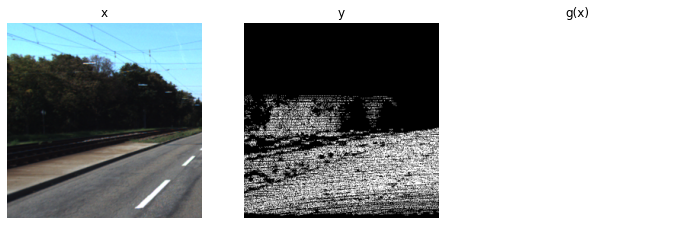

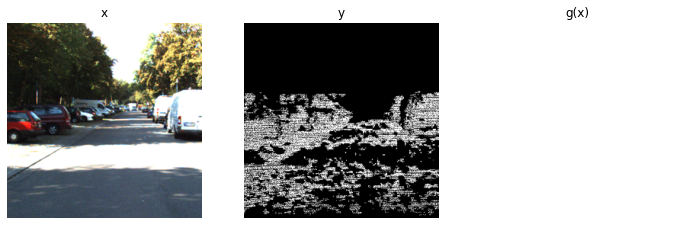

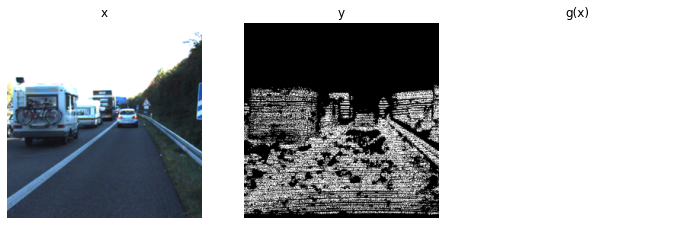

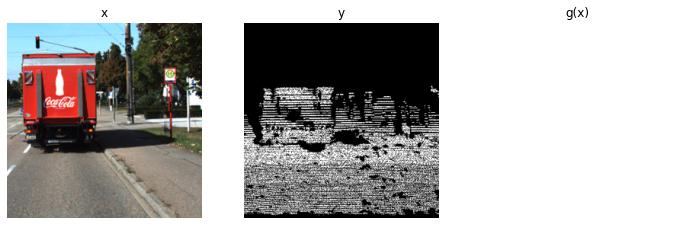

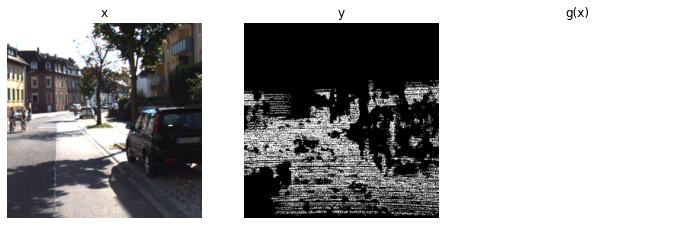

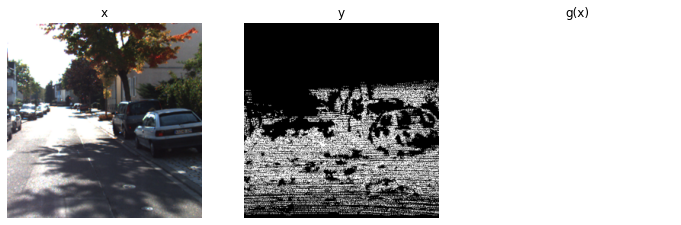

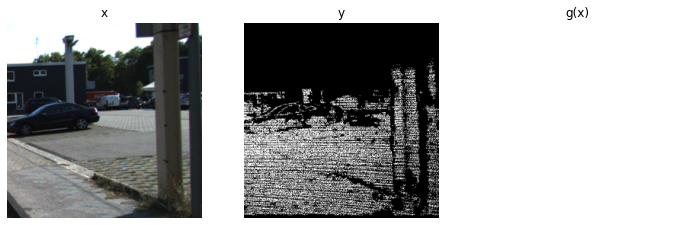

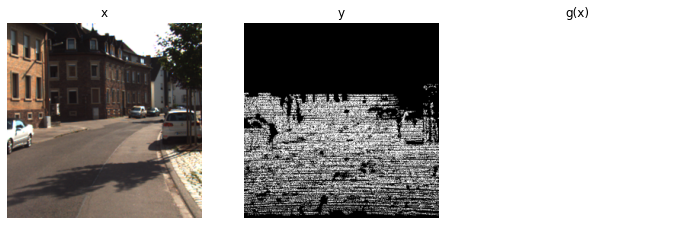

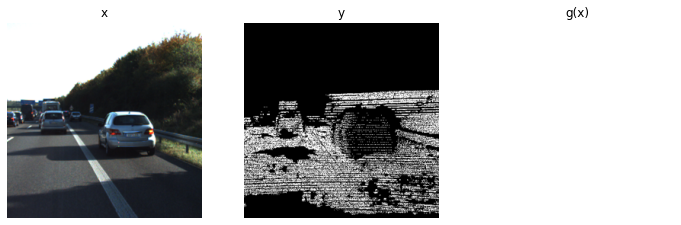

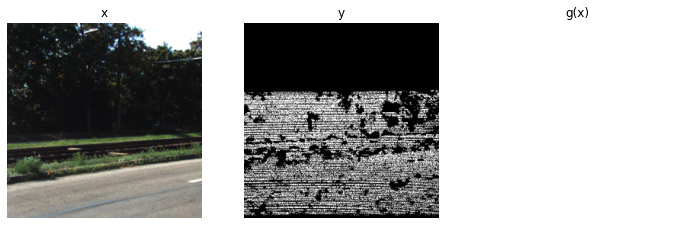

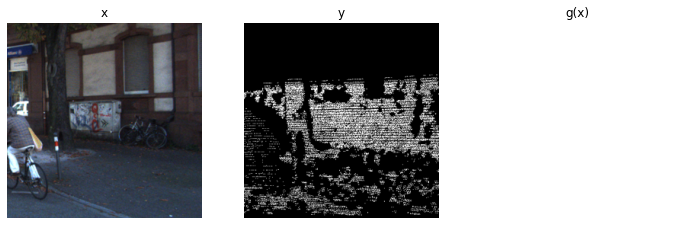

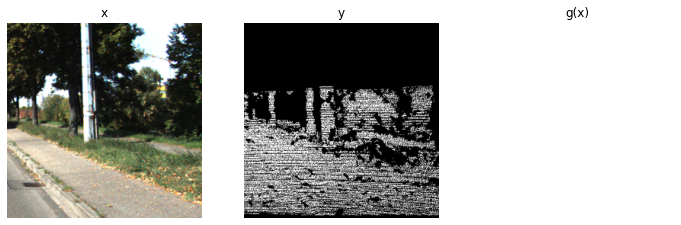

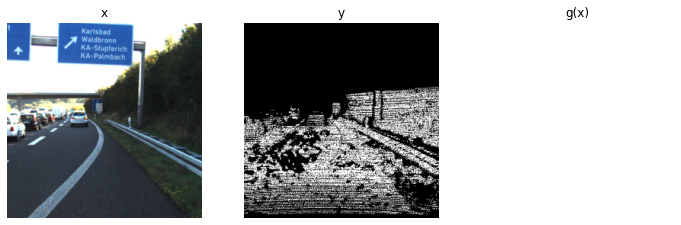

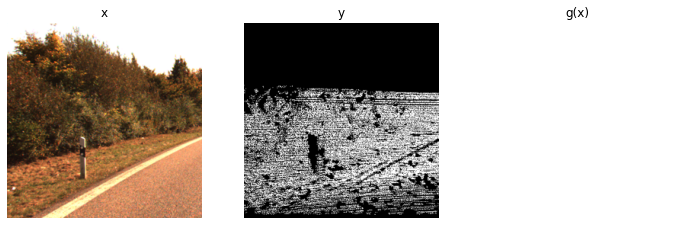

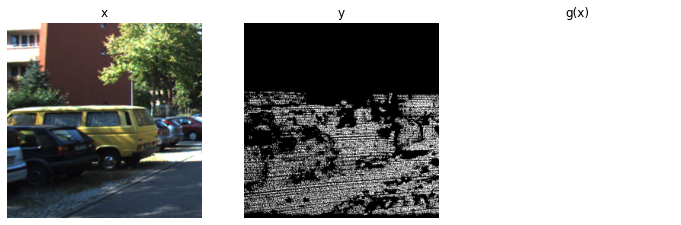

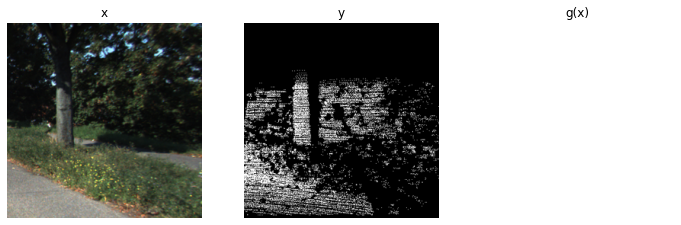

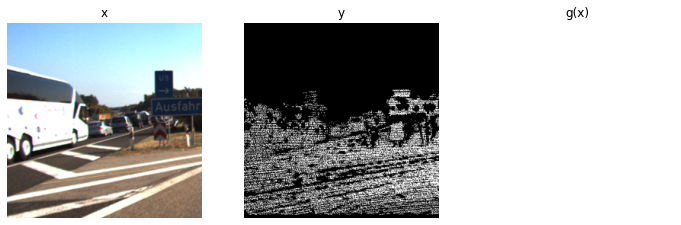

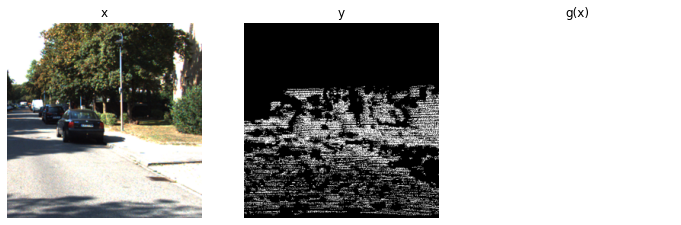

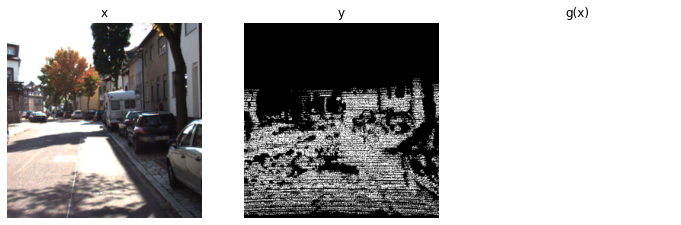

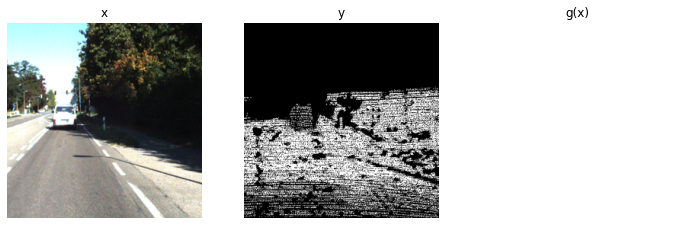

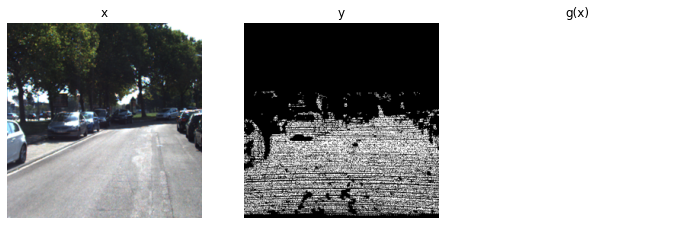

In [30]:
out = model.predict(test_x, batch_size=10)
for i in range(len(out)):
    fig, ax = plt.subplots(1,3,figsize=(10,10))
    fig.tight_layout()
    ax = ax.flatten()

    x = test_x[i]
    y = test_y[i]
    o = out[i]
    
    ax[0].imshow(x)
    ax[0].set_title("x")
    ax[0].axis("off")
    ax[1].imshow(y)
    ax[1].set_title("y")
    ax[1].axis("off")
    ax[2].imshow(o)
    ax[2].set_title("g(x)")
    ax[2].axis("off")